
# Balance Estructural (lite) — Bolivia (x11..x95)

Este cuaderno estima un **Balance Estructural (BEP/BE)** mínimo usando solo:
- `x11` = Ingresos totales del TGN  
- `x35` = Egresos totales del TGN  
- `x44` + `x45` = Intereses (externa + interna)  
- `x94` = PIB nominal  
- `x95` = PIB real  

Ajusta por ciclo solo los ingresos vía una elasticidad agregada `β` (OLS) y la brecha del producto (HP λ=1600).  
No se ajusta el gasto (Bolivia no tiene seguro de desempleo relevante).


In [1]:

# (Opcional) Instala dependencias si no las tienes en tu entorno:
# %pip install -q pandas statsmodels matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, Tuple

from statsmodels.tsa.filters.hp_filter import hpfilter
import statsmodels.api as sm

pd.set_option("display.max_columns", 999)


## Configuración

In [2]:

# Ruta a tu archivo de datos (CSV o Excel)
PATH_INPUT = "dataset.csv"   # <-- cambia por tu archivo real
SHEET_NAME = None            # si es Excel y quieres especificar la hoja

# Fecha: usa una sola columna (por defecto 'date') o (year, quarter)
DATE_MODE = "single"         # "single" | "yq"
DATE_COL  = "date"           # si DATE_MODE == "single"
YEAR_COL  = "year"           # si DATE_MODE == "yq"
QUARTER_COL = "quarter"      # si DATE_MODE == "yq"

# Método para brecha del producto (usamos HP por simplicidad)
HP_LAMBDA = 1600

# Mapeo de columnas (según tus etiquetas x11..x95)
COLS = {
    "ingresos_totales": "x11",
    "egresos_totales": "x35",
    "int_ext": "x44",      # si falta, el código asume 0
    "int_int": "x45",
    "pib_nom": "x94",
    "pib_real": "x95",
}


## Funciones auxiliares

In [3]:

def to_period_quarter(series: pd.Series) -> pd.PeriodIndex:
    # Convierte strings tipo 'YYYYQn' o fechas a PeriodIndex trimestral
    def conv(x):
        x = str(x).strip().upper()
        if "Q" in x:
            y, q = x.split("Q")
            return pd.Period(year=int(y), quarter=int(q), freq="Q")
        dt = pd.to_datetime(x, errors="coerce")
        if pd.isna(dt):
            raise ValueError(f"No pude parsear fecha '{x}'. Usa 'YYYYQn' o una fecha válida.")
        return dt.to_period("Q")
    return pd.PeriodIndex(series.map(conv), name="tq")

def ensure_quarterly_index(df: pd.DataFrame) -> pd.DataFrame:
    if DATE_MODE == "single":
        if DATE_COL not in df.columns:
            raise ValueError(f"Falta columna de fecha '{DATE_COL}'.")
        df = df.copy()
        df.index = to_period_quarter(df[DATE_COL])
        return df.sort_index()
    else:
        if (YEAR_COL not in df.columns) or (QUARTER_COL not in df.columns):
            raise ValueError(f"Faltan '{YEAR_COL}' y/o '{QUARTER_COL}'.")
        per = [pd.Period(year=int(y), quarter=int(q), freq="Q") for y, q in zip(df[YEAR_COL], df[QUARTER_COL])]
        df = df.copy()
        df.index = pd.PeriodIndex(per, name="tq")
        return df.sort_index()

def output_gap_hp(y_real: pd.Series, hp_lambda: int = 1600) -> Tuple[pd.Series, pd.Series]:
    trend, cyc = hpfilter(y_real, lamb=hp_lambda)
    y_pot = trend
    og = (y_real - y_pot) / y_pot
    return y_pot, og

def estimate_beta_ols(ingresos: pd.Series, pib_real: pd.Series) -> float:
    # Elasticidad β: Δln(T) vs Δln(PIB_real)
    dT = np.log(ingresos.replace(0, np.nan)).diff()
    dY = np.log(pib_real.replace(0, np.nan)).diff()
    df = pd.concat([dT, dY], axis=1, keys=["dT","dY"]).dropna()
    X = sm.add_constant(df["dY"])
    res = sm.OLS(df["dT"], X).fit()
    return float(res.params["dY"])


## Cargar datos

In [4]:

# Lee CSV o Excel de forma automática
if str(PATH_INPUT).lower().endswith((".xlsx",".xls")):
    raw = pd.read_excel(PATH_INPUT, sheet_name=SHEET_NAME)
else:
    raw = pd.read_csv(PATH_INPUT)

raw = ensure_quarterly_index(raw)
raw.head()


ValueError: Falta columna de fecha 'date'.

In [5]:
import pandas as pd


raw = pd.read_csv("dataset.csv")

In [7]:

raw.head()

,Date,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95
0,1990Q1,"1,052.86",963.16,231.14,178.27,50.14,2.72,-,-,-,-,408.90,238.19,170.71,205.23,113.76,91.47,22.96,94.94,47.72,-,47.22,89.69,84.41,5.28,"1,080.73",863.22,295.50,12.70,17.97,264.83,290.13,35.28,254.85,81.10,27.97,26.90,1.07,82.49,-,22.93,59.56,63.07,-,-,-,-,63.07,22.97,-,-,-,-,-,-,217.51,99.94,81.19,(27.88),(27.88),27.88,(57.35),75.05,NaN,0.0,-36.570,37.842,-4.450,-44.52000,-84.69544,0.0,85.221800,35.090,26.9,8.190,25.31280,1.420000,23.399000,-2.470000,17.669,0.0,NaN,8.20,NaN,3557.912390,3587.595277
1,1990Q2,"1,177.06","1,115.34",311.47,257.21,48.35,5.91,-,-,-,-,446.44,269.41,177.03,219.23,124.31,94.91,29.46,108.75,54.41,-,54.34,61.71,55.49,6.22,"1,313.01","1,065.12",388.16,19.82,31.67,336.67,359.34,37.18,322.15,147.24,27.62,26.70,0.92,86.51,-,23.54,62.97,79.34,-,-,-,-,79.34,(23.08),-,-,-,-,-,-,247.88,50.22,38.90,(135.95),(135.95),135.95,111.97,84.27,NaN,0.0,-54.378,98.580,-1.910,33.39000,-47.98620,0.0,23.982460,25.540,26.7,-1.160,-0.48654,16.090000,-17.161000,-12.260000,-6.301,0.0,NaN,1.40,NaN,3754.367649,3926.068381
2,1990Q3,"1,251.80","1,168.73",257.14,207.61,46.05,3.48,-,-,-,-,513.56,331.49,182.07,240.32,134.06,106.26,34.51,123.20,58.85,-,64.34,83.07,75.29,7.79,"1,346.01","1,024.82",364.16,13.71,19.22,331.24,349.83,37.73,312.10,80.77,28.42,27.50,0.92,112.75,-,27.78,84.97,92.62,-,-,-,-,92.62,(3.73),-,-,-,-,-,-,321.19,143.91,14.98,(94.21),(94.21),94.21,91.27,166.63,NaN,0.0,-38.160,33.708,-2.545,-68.37000,0.00000,0.0,2.945520,42.397,27.5,14.897,-40.50048,-1.061000,2.110000,2.540000,7.670,0.0,NaN,-8.10,NaN,4028.537972,3934.132611
3,1990Q4,"1,270.96","1,191.09",273.23,224.53,44.27,4.43,-,-,-,-,492.48,319.66,172.82,259.59,160.79,98.81,38.08,127.71,69.87,-,57.83,79.87,68.57,11.30,"1,687.49","1,197.60",530.90,16.78,36.18,477.94,366.72,41.95,324.78,152.96,15.73,15.00,0.73,111.23,-,32.58,78.65,110.11,-,-,-,-,110.11,(90.05),-,-,-,-,-,-,489.89,(6.51),(247.83),(416.52),(416.52),416.52,232.20,235.64,NaN,0.0,-64.236,86.496,-0.319,20.03400,-45.41676,0.0,184.328540,221.567,15.0,206.567,0.48654,-1.755000,-35.970000,-16.300000,-16.220,0.0,NaN,-3.45,NaN,4102.318450,3995.340192
4,1991Q1,"1,206.80","1,150.52",273.23,231.29,39.40,2.54,-,-,-,-,501.64,342.45,159.19,229.73,136.78,92.95,35.51,110.42,60.43,-,49.99,56.28,43.01,13.26,"1,342.66","1,010.67",360.72,10.89,23.05,326.78,353.82,31.97,321.85,107.16,36.28,35.80,0.48,109.90,19.08,32.44,58.38,64.49,-,-,-,-,64.49,(21.70),-,-,-,-,-,-,331.99,139.85,7.58,(135.86),(135.86),135.86,93.32,117.84,NaN,0.0,-40.940,44.144,-2.848,-24.87016,0.00000,0.0,42.541786,-13.104,35.8,-48.904,16.48992,39.964462,-0.808596,0.451404,-1.560,0.0,0.0,0.30,NaN,4364.334381,3677.805793


In [9]:
# === Config ===
PATH_INPUT = "dataset.csv"
SHEET_NAME = None

DATE_MODE = "single"      # "single" | "yq"
DATE_COL  = "Date"        # <-- tu columna es 'Date' con D mayúscula

HP_LAMBDA = 1600

# Mapeo usando MAYÚSCULAS como en tu CSV
COLS = {
    "ingresos_totales": "X11",
    "egresos_totales": "X35",
    "int_ext": "X44",
    "int_int": "X45",
    "pib_nom": "X94",
    "pib_real": "X95",
}


In [10]:
# Lee CSV/Excel
if str(PATH_INPUT).lower().endswith((".xlsx",".xls")):
    raw = pd.read_excel(PATH_INPUT, sheet_name=SHEET_NAME)
else:
    raw = pd.read_csv(PATH_INPUT, thousands=",", skipinitialspace=True)

# Limpia espacios en nombres de columnas (por si acaso)
raw.columns = raw.columns.str.strip()

# Índice trimestral desde 'Date'
raw = ensure_quarterly_index(raw)
raw.head()


ValueError: No pude parsear fecha 'NAN'. Usa 'YYYYQn' o una fecha válida.

In [11]:
def safe_series(df, col):
    """Devuelve la serie numérica si existe; si no, una serie de ceros con el mismo índice."""
    if col in df.columns:
        s = pd.to_numeric(df[col], errors="coerce")
        return s.fillna(0.0).astype(float)
    else:
        return pd.Series(0.0, index=df.index, dtype=float)

# Series principales (todas en MAYÚSCULAS)
T_total = safe_series(raw, COLS["ingresos_totales"])  # X11
G_total = safe_series(raw, COLS["egresos_totales"])   # X35
pib_nom = safe_series(raw, COLS["pib_nom"])           # X94
pib_real = safe_series(raw, COLS["pib_real"])         # X95

# Intereses: sumamos si existen; si no, quedan en 0
int_ext = safe_series(raw, COLS["int_ext"])           # X44
int_int = safe_series(raw, COLS["int_int"])           # X45
INTERESES = (int_ext + int_int).astype(float)

# Brecha del producto (HP)
y_pot, OG = output_gap_hp(pib_real, HP_LAMBDA)

# Elasticidad agregada β
beta = estimate_beta_ols(T_total, pib_real)
beta


0.8742368844206614

## Preparar series y parámetros

In [12]:

# Series principales
T_total = pd.to_numeric(raw[COLS["ingresos_totales"]], errors="coerce").astype(float)
G_total = pd.to_numeric(raw[COLS["egresos_totales"]], errors="coerce").astype(float)
pib_nom = pd.to_numeric(raw[COLS["pib_nom"]], errors="coerce").astype(float)
pib_real = pd.to_numeric(raw[COLS["pib_real"]], errors="coerce").astype(float)

# Intereses: suma de las columnas disponibles
int_ext = pd.to_numeric(raw.get(COLS["int_ext"], 0.0), errors="coerce").fillna(0.0)
int_int = pd.to_numeric(raw.get(COLS["int_int"], 0.0), errors="coerce").fillna(0.0)
INTERESES = (int_ext + int_int).astype(float)

# Brecha del producto (HP)
y_pot, OG = output_gap_hp(pib_real, HP_LAMBDA)

# Elasticidad agregada β
beta = estimate_beta_ols(T_total, pib_real)
beta


0.8742368844206614

## Cálculo: CC de ingresos, BEP, BE y FI

In [13]:

# Componente cíclico de ingresos (sin desagregar recursos)
CC_T = beta * OG * T_total

# Gasto primario (no ajustado por ciclo)
G_primario = G_total - INTERESES

# Ingresos/Gasto estructural
T_estr = (T_total - CC_T)
G_primario_estr = G_primario

# Saldos (% del PIB nominal)
BEP = (T_estr - G_primario_estr) / pib_nom
BE  = BEP - (INTERESES / pib_nom)

# Impulso fiscal: -ΔBEP
FI = -BEP.diff()

res = pd.DataFrame({
    "PIB_nom": pib_nom,
    "PIB_real": pib_real,
    "PIB_pot": y_pot,
    "OG": OG,
    "Ingresos_totales": T_total,
    "Egresos_totales": G_total,
    "Intereses": INTERESES,
    "Beta": beta,
    "CC_Ingresos": CC_T,
    "G_primario": G_primario,
    "T_estructural": T_estr,
    "G_primario_estr": G_primario_estr,
    "BEP": BEP,
    "BE": BE,
    "FI": FI
})
res.tail()


,PIB_nom,PIB_real,PIB_pot,OG,Ingresos_totales,Egresos_totales,Intereses,Beta,CC_Ingresos,G_primario,T_estructural,G_primario_estr,BEP,BE,FI
414,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.874237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.874237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
416,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.874237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.874237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.874237,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Gráficos rápidos

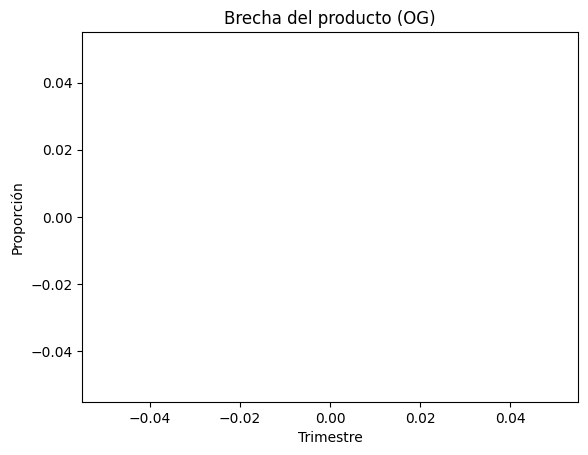

<Figure size 640x480 with 0 Axes>

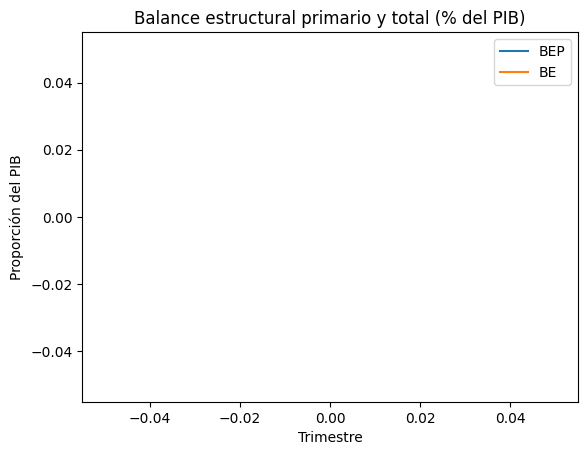

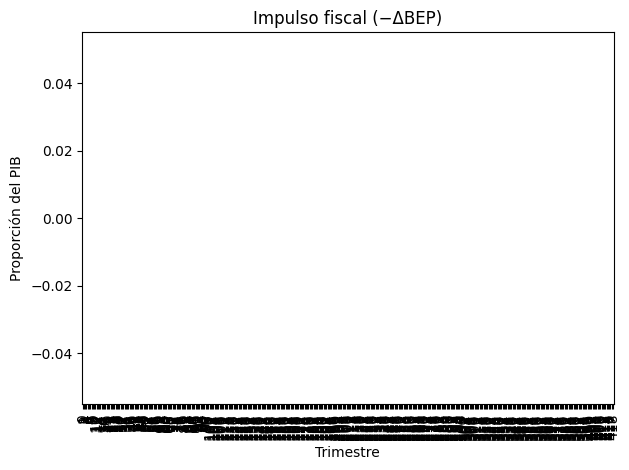

In [14]:

# Brecha del producto (OG)
plt.figure()
res["OG"].plot()
plt.title("Brecha del producto (OG)")
plt.xlabel("Trimestre"); plt.ylabel("Proporción")
plt.show()

# BEP y BE
plt.figure()
res[["BEP","BE"]].plot()
plt.title("Balance estructural primario y total (% del PIB)")
plt.xlabel("Trimestre"); plt.ylabel("Proporción del PIB")
plt.show()

# Impulso fiscal
plt.figure()
res["FI"].plot(kind="bar")
plt.title("Impulso fiscal (−ΔBEP)")
plt.xlabel("Trimestre"); plt.ylabel("Proporción del PIB")
plt.tight_layout()
plt.show()


## Exportar resultados

In [15]:

OUT_PATH = "be_results_x11_x95.csv"
res.to_csv(OUT_PATH, index=True)
OUT_PATH


'be_results_x11_x95.csv'


### Próximos pasos
- Desagregar ingresos por recursos vs no recursos y ajustar recursos a precio de referencia.
- Sensibilidad: OG con Hamilton, β por rubros (IVA, Renta aduanera, etc.).
- Reportar variante BEP sin pensiones si lo necesitas.
